In [22]:
import cv2
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import os
import matplotlib.pyplot as plt


In [23]:
model_path = "pb"
model = tf.saved_model.load(model_path)
movenet = model.signatures['serving_default']


In [24]:
LEFT_ELBOW_IDX = 7
RIGHT_ELBOW_IDX = 8


In [25]:
with open('punch_coordinates2.txt', 'w') as f:
    cap = cv2.VideoCapture('video2.mp4')

    while True:
        ret, frame = cap.read()

        if not ret:
            break

        frame_height, frame_width, _ = frame.shape
        image = tf.expand_dims(frame, axis=0)
        image = tf.cast(tf.image.resize_with_pad(
            image, 192, 192), dtype=tf.int32)
        outputs = movenet(image)
        keypoints = np.squeeze(outputs['output_0'])
        left_elbow_coords = None
        right_elbow_coords = None

        if keypoints.ndim == 2:
            if LEFT_ELBOW_IDX < keypoints.shape[0]:
                left_elbow_coords = (int(keypoints[LEFT_ELBOW_IDX][1] * frame_width), int(
                    keypoints[LEFT_ELBOW_IDX][0] * frame_height))
            if RIGHT_ELBOW_IDX < keypoints.shape[0]:
                right_elbow_coords = (int(keypoints[RIGHT_ELBOW_IDX][1] * frame_width), int(
                    keypoints[RIGHT_ELBOW_IDX][0] * frame_height))

        elif keypoints.ndim == 3:
            max_score_idx = np.argmax(keypoints[:, :, 2])
            if LEFT_ELBOW_IDX < keypoints.shape[1]:
                left_elbow_coords = (int(
                    keypoints[max_score_idx, LEFT_ELBOW_IDX][1] * frame_width), int(keypoints[max_score_idx, LEFT_ELBOW_IDX][0] * frame_height))
            if RIGHT_ELBOW_IDX < keypoints.shape[1]:
                right_elbow_coords = (int(
                    keypoints[max_score_idx, RIGHT_ELBOW_IDX][1] * frame_width), int(keypoints[max_score_idx, RIGHT_ELBOW_IDX][0] * frame_height))
                
        if left_elbow_coords is not None and right_elbow_coords is not None:
            f.write(f"{left_elbow_coords},{right_elbow_coords}\n")
    cap.release()


In [26]:
def plot_punch_dynamics(file_path):
    with open(file_path, 'r') as f:
        data = f.read()

    data = data.split('\n')
    x_l = [int(d.split(',')[0][1:]) for d in data[:-1]]
    y_l = [int(d.split(',')[1][1:-1]) for d in data[:-1]]
    x_r = [int(d.split(',')[2][1:]) for d in data[:-1]]
    y_r = [int(d.split(',')[3][1:-1]) for d in data[:-1]]

    dx_l = [x_l[i+1] - x_l[i] for i in range(len(x_l)-1)]
    dy_l = [y_l[i+1] - y_l[i] for i in range(len(y_l)-1)]
    dx_r = [x_r[i+1] - x_r[i] for i in range(len(x_r)-1)]
    dy_r = [y_r[i+1] - y_r[i] for i in range(len(y_r)-1)]
    plt.plot(dx_l, dy_l, label='Left Elbow')
    plt.plot(dx_r, dy_r, label='Right Elbow')

    plt.title('Punch Dynamics')
    plt.xlabel('Delta X')
    plt.ylabel('Delta Y')
    plt.legend()
    plt.show()


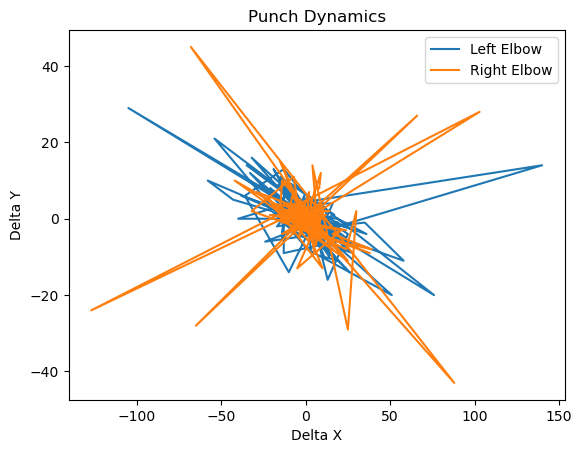

In [21]:
plot_punch_dynamics("punch_coordinates.txt")


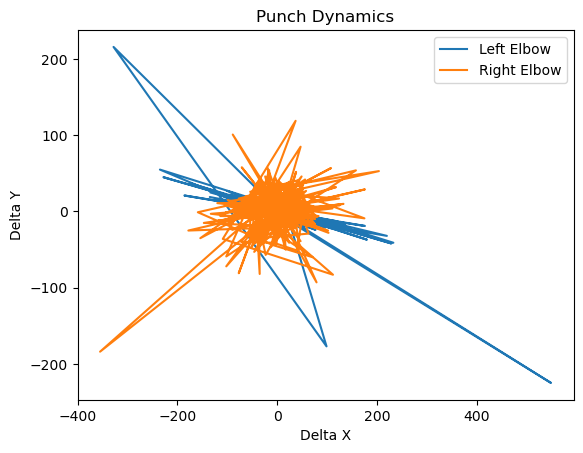

In [27]:
plot_punch_dynamics("punch_coordinates2.txt")


Graphs above represent vector change (delta) of elbow position by x,y- axis from the initial position. By using definitions of precision and variation, it can be predicted, that the 1st picture describes puch movements from video.mp4, while 2nd picture shows vectors in peaceful walk from video2.mp4

In [39]:
def plot_punch_dynamics2(file_path):
    with open(file_path, 'r', encoding='latin-1') as f:
        data = f.readlines()

    left_elbow_coords = []
    right_elbow_coords = []

    for line in data:
        coords = line.strip().split(',')
        left_elbow_coords.append(float(coords[0].strip('()')))
        right_elbow_coords.append(float(coords[1].strip('()')))

    x = np.linspace(0, len(left_elbow_coords), num=len(
        left_elbow_coords), endpoint=False)

    left_elbow_interp = np.interp(
        x, range(len(left_elbow_coords)), left_elbow_coords)
    right_elbow_interp = np.interp(
        x, range(len(right_elbow_coords)), right_elbow_coords)

    plt.plot(x, left_elbow_interp, label='Left elbow')
    plt.plot(x, right_elbow_interp, label='Right elbow')
    plt.legend()
    plt.xlabel('Frame number')
    plt.ylabel('Elbow coordinate')
    plt.title('Dynamics of the punch')
    plt.show()


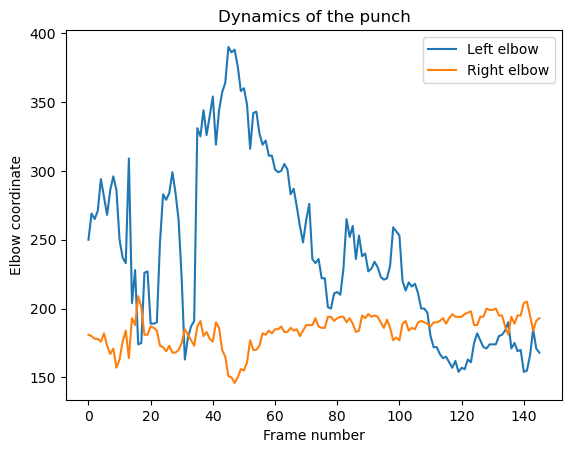

In [41]:
plot_punch_dynamics2("punch_coordinates.txt")


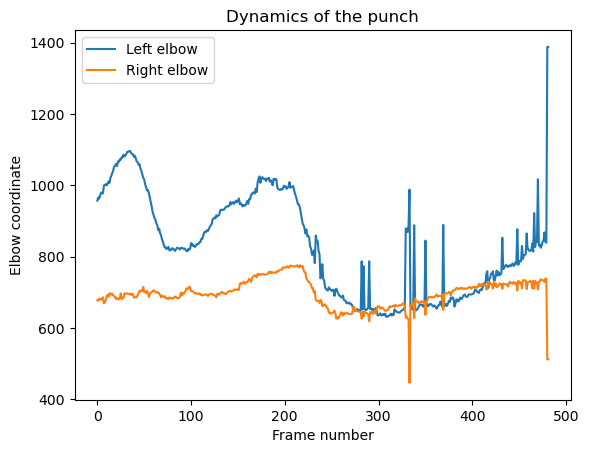

In [42]:
plot_punch_dynamics2("punch_coordinates2.txt")


Graphs above reveal dynamic change of position of coordinates. The use set of scalar values (points) by x and y axis to draw a general dynamics of elbow movement. 1st picture describes punch movement from video.mp4, 2nd picture uses video2.mp4 peaceful walk movements.

In [64]:
def plot_velocity_rate(doc_path):
    with open(doc_path, 'r') as f:
        data = f.read().splitlines()
    left_coords = []
    right_coords = []
    for d in data:
        l, r = d[1:-1].split('),(')
        left_coords.append([int(c) for c in l.split(',')])
        right_coords.append([int(c) for c in r.split(',')])
    left_velocities = np.diff(left_coords, axis=0)
    right_velocities = np.diff(right_coords, axis=0)

    left_accelerations = np.diff(left_velocities, axis=0)
    right_accelerations = np.diff(right_velocities, axis=0)

    left_accel_magnitudes = np.linalg.norm(left_accelerations, axis=1)
    right_accel_magnitudes = np.linalg.norm(right_accelerations, axis=1)

    fig, ax = plt.subplots()
    ax.plot(left_accel_magnitudes, label='Left elbow acceleration')
    ax.plot(right_accel_magnitudes, label='Right elbow acceleration')
    ax.legend()
    ax.set_xlabel('Time (frames)')
    ax.set_ylabel('Acceleration magnitude')
    ax.set_title('Rate of change of velocity of elbow coordinates over time')
    plt.show()


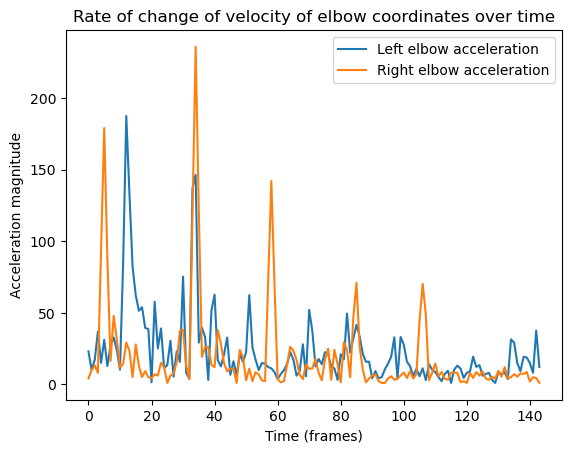

In [65]:
plot_velocity_rate("punch_coordinates.txt")


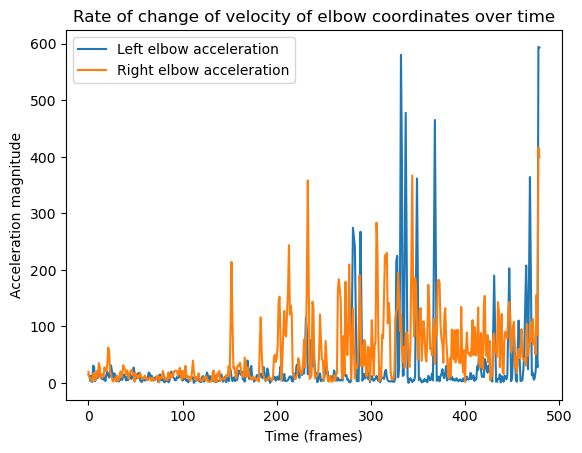

In [66]:
plot_velocity_rate("punch_coordinates2.txt")


Graphs above are less representative, however reveal acceleration of elbows through frames (time). Conclusions cannot be clearly made whether it is punch or not.